This post documents an attempt at reproducing a [study of ocean color optical water types (OWT)](http://ieeexplore.ieee.org/document/942555/). Here, remote sensing reflectance (Rrs) was used to classify regions of the ocean according to their [apparent optical properties](https://en.wikipedia.org/wiki/Water_remote_sensing)
The author uses fuzzy c-means (FCM) clustering. However, [K-means clustering yields results that are pretty close to FMC](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.403.7600&rep=rep1&type=pdf). So that's what I'll use here. This post will go somewhat slow as it is intended for people relatively new to both python and machine learning.
<!-- TEASER_END -->

In [1]:
from sklearn.cluster import KMeans as KM
import os
from scipy.io import loadmat as LM
import pandas as PD
import seaborn as SB
import numpy as NP
from matplotlib import rcParams
import matplotlib.pyplot as pl
from sklearn.preprocessing import StandardScaler
%matplotlib inline
# setting precision across the notebook to 2 decimals
%precision 3

'%.3f'

Additional graphic settings

In [2]:
rcParams['axes.formatter.limits']=(-2,3)
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['font.size'] = 16

SB.set_style(rc=rcParams)
SB.set(context='notebook',font_scale=2)

In [3]:
# Specifying data file paths
maindir = '/home/madhatter106/DATA/OceanColor/OWT/'
fname = 'nomad_rrs4clustering.mat'
fpath = os.path.join(maindir,fname)

This is a MATLAB data file, so I'll use scipy's loadmat method to load a MATLAB namespace into a dictionary.

In [4]:
timNomadRrs = LM(fpath)

Taking a look at the dictionary keys...

In [5]:
timNomadRrs.keys()

dict_keys(['__header__', 'chl_nomad', 'lon_nomad', 'rrs_below', 'lat_nomad', 'wl', '__globals__', '__version__'])

Dictionary keys are:
* wl: wavelength
* lat_nomad: latitude
* lon_nomad: longitude
* chl_nomad: chlorophyll *a*
* rrs_below: sub-surface 

I'll assign the data to separate containers.

In [6]:
wavelength = timNomadRrs['wl']
lat = timNomadRrs['lat_nomad']
lon = timNomadRrs['lon_nomad']
rrsBelow = timNomadRrs['rrs_below']
chl = timNomadRrs['chl_nomad'] # I might use this as an additional feature in clustering

In [26]:
geoLbl = ['lat', 'lon']
wlLbl = list(wavelength[0])
prodLbl = ['chl']
labels = geoLbl + wlLbl + prodLbl
df = PD.DataFrame(data=NP.hstack((lat,lon,rrsBelow,chl)), columns=labels)

In [8]:
df.head()

,lat,lon,411,443,469,489,510,520,547,550,555,560,565,670,chl
0,38.4279,-76.61,0.002307,0.003225,0.004674,0.006265,0.007661,0.008944,0.012935,0.013410,0.014040,0.014715,0.015325,0.006588,38.19
1,38.3680,-76.50,0.002035,0.002650,0.003273,0.004149,0.004767,0.005416,0.007338,0.007570,0.007878,0.008208,0.008549,0.003241,35.01
2,38.3074,-76.44,0.001862,0.002271,0.002654,0.003523,0.004367,0.005147,0.007423,0.007691,0.008053,0.008434,0.008822,0.003084,26.91
3,38.6367,-76.32,0.002817,0.003330,0.004096,0.005482,0.006963,0.008243,0.012075,0.012525,0.013127,0.013770,0.014361,0.006154,47.96
4,38.3047,-76.44,0.001735,0.001959,0.002129,0.002882,0.003638,0.004115,0.005079,0.005191,0.005337,0.005507,0.005716,0.003423,23.55


In [9]:
df.describe()

,lat,lon,411,443,469,489,510,520,547,550,555,560,565,670,chl
count,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000
mean,21.481930,-64.103323,0.009913,0.009351,0.009408,0.009086,0.007638,0.007200,0.006301,0.006246,0.006105,0.005999,0.005913,0.001289,1.544312
std,30.793904,62.277488,0.006548,0.005329,0.005020,0.004598,0.004656,0.004964,0.005866,0.005977,0.006091,0.006254,0.006359,0.002629,4.002408
min,-76.633000,-179.955000,0.000098,0.000365,0.000429,0.000546,0.000502,0.000463,0.000404,0.000410,0.000398,0.000374,0.000362,0.000023,0.000000
25%,22.893175,-118.275500,0.005000,0.005335,0.005714,0.006135,0.005511,0.004927,0.003390,0.003257,0.003029,0.002801,0.002599,0.000196,0.054000
50%,31.792500,-75.494750,0.007967,0.008120,0.008610,0.008528,0.006562,0.005780,0.004292,0.004185,0.003970,0.003761,0.003624,0.000385,0.301200
75%,36.829250,-54.195000,0.013895,0.012699,0.012526,0.011118,0.007965,0.007237,0.006257,0.006207,0.006047,0.005934,0.005880,0.001101,1.218750
max,79.000000,179.907000,0.039485,0.031489,0.042271,0.046573,0.050136,0.051616,0.057989,0.059072,0.060087,0.061543,0.062095,0.031832,72.120000


For context, and since geolocation is provided, I'll map these data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2404 entries, 0 to 2403
Data columns (total 15 columns):
lat    2404 non-null float64
lon    2404 non-null float64
411    2404 non-null float64
443    2404 non-null float64
469    2404 non-null float64
489    2404 non-null float64
510    2404 non-null float64
520    2404 non-null float64
547    2404 non-null float64
550    2404 non-null float64
555    2404 non-null float64
560    2404 non-null float64
565    2404 non-null float64
670    2404 non-null float64
chl    2404 non-null float64
dtypes: float64(15)
memory usage: 281.8 KB


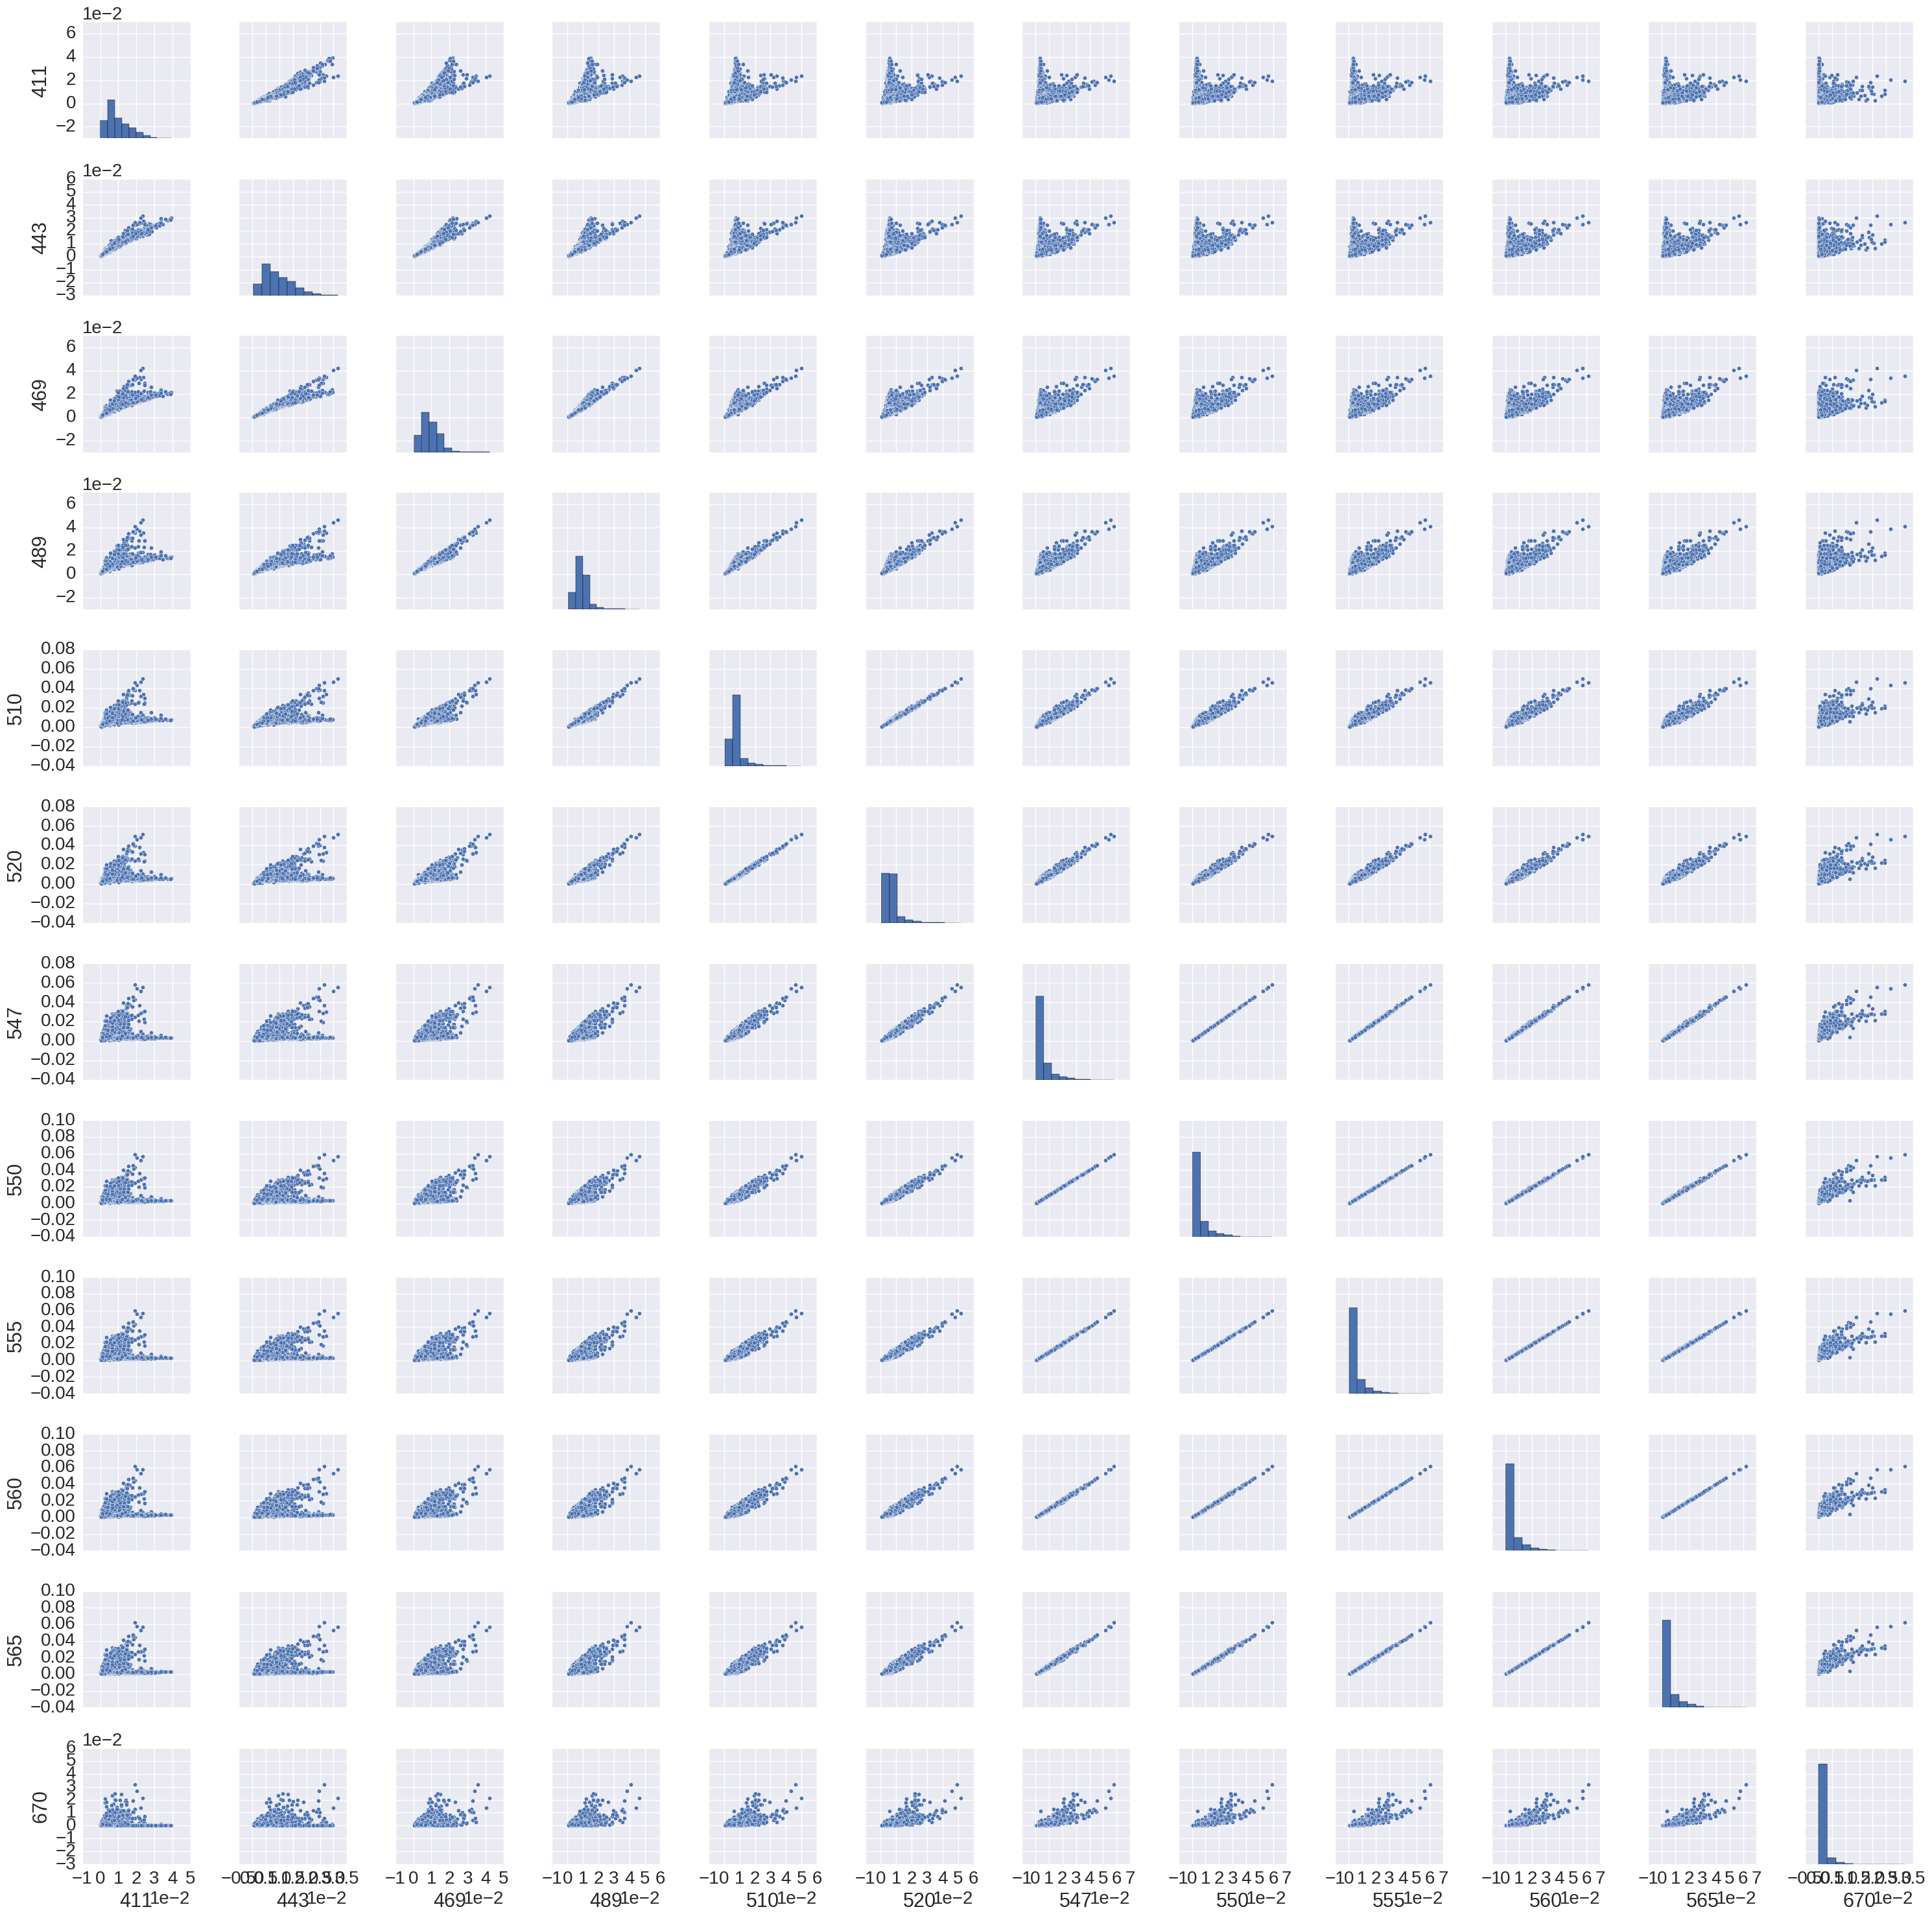

In [11]:
SB.pairplot(df.loc[:,wlLbl]);

The plot above shows high correlation among bands, mostly between bands that are close to each other.

Moore *et al.* (2001) use only the lower five SeaWiFs visible bands, and that's how OWT is implemented in the [Ocean Biology Processing Group](https://oceancolor.gsfc.nasa.gov/)'s. These would correspond here to 411, 443, 489, 510, 555. I'll replot the above with just those bands.

In [27]:
sc = StandardScaler()
lbls = wlLbl + prodLbl
dataStd = sc.fit_transform(df.loc[:,lbls].values)
dfStd = PD.DataFrame(dataStd,columns=lbls)
dfStd.describe()

,411,443,469,489,510,520,547,550,555,560,565,670,chl
count,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03
mean,1.108376e-16,-5.338676e-17,-1.560962e-17,8.913188e-17,-4.858380e-17,-1.423339e-16,-5.625007e-17,-4.733688e-17,1.763010e-16,3.183925e-16,5.384859e-17,-3.461365e-17,-7.287570e-17
std,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00
min,-1.499165e+00,-1.686430e+00,-1.788811e+00,-1.857760e+00,-1.533065e+00,-1.357243e+00,-1.005421e+00,-9.765209e-01,-9.370233e-01,-8.996961e-01,-8.731992e-01,-4.819356e-01,-3.859260e-01
25%,-7.504352e-01,-7.537173e-01,-7.359950e-01,-6.419132e-01,-4.568864e-01,-4.578923e-01,-4.962801e-01,-5.001160e-01,-5.049955e-01,-5.113855e-01,-5.211910e-01,-4.158278e-01,-3.724313e-01
50%,-2.972898e-01,-2.310136e-01,-1.589268e-01,-1.214855e-01,-2.310029e-01,-2.861123e-01,-3.424316e-01,-3.448293e-01,-3.506027e-01,-3.578891e-01,-3.600168e-01,-3.440910e-01,-3.106557e-01
75%,6.081378e-01,6.284834e-01,6.212235e-01,4.419674e-01,7.039356e-02,7.483167e-03,-7.431775e-03,-6.504881e-03,-9.454504e-03,-1.038570e-02,-5.095303e-03,-7.148734e-02,-8.135848e-02
max,4.516979e+00,4.154953e+00,6.547083e+00,8.154232e+00,9.130229e+00,8.948706e+00,8.812843e+00,8.839424e+00,8.864605e+00,8.883801e+00,8.837111e+00,1.162061e+01,1.763697e+01


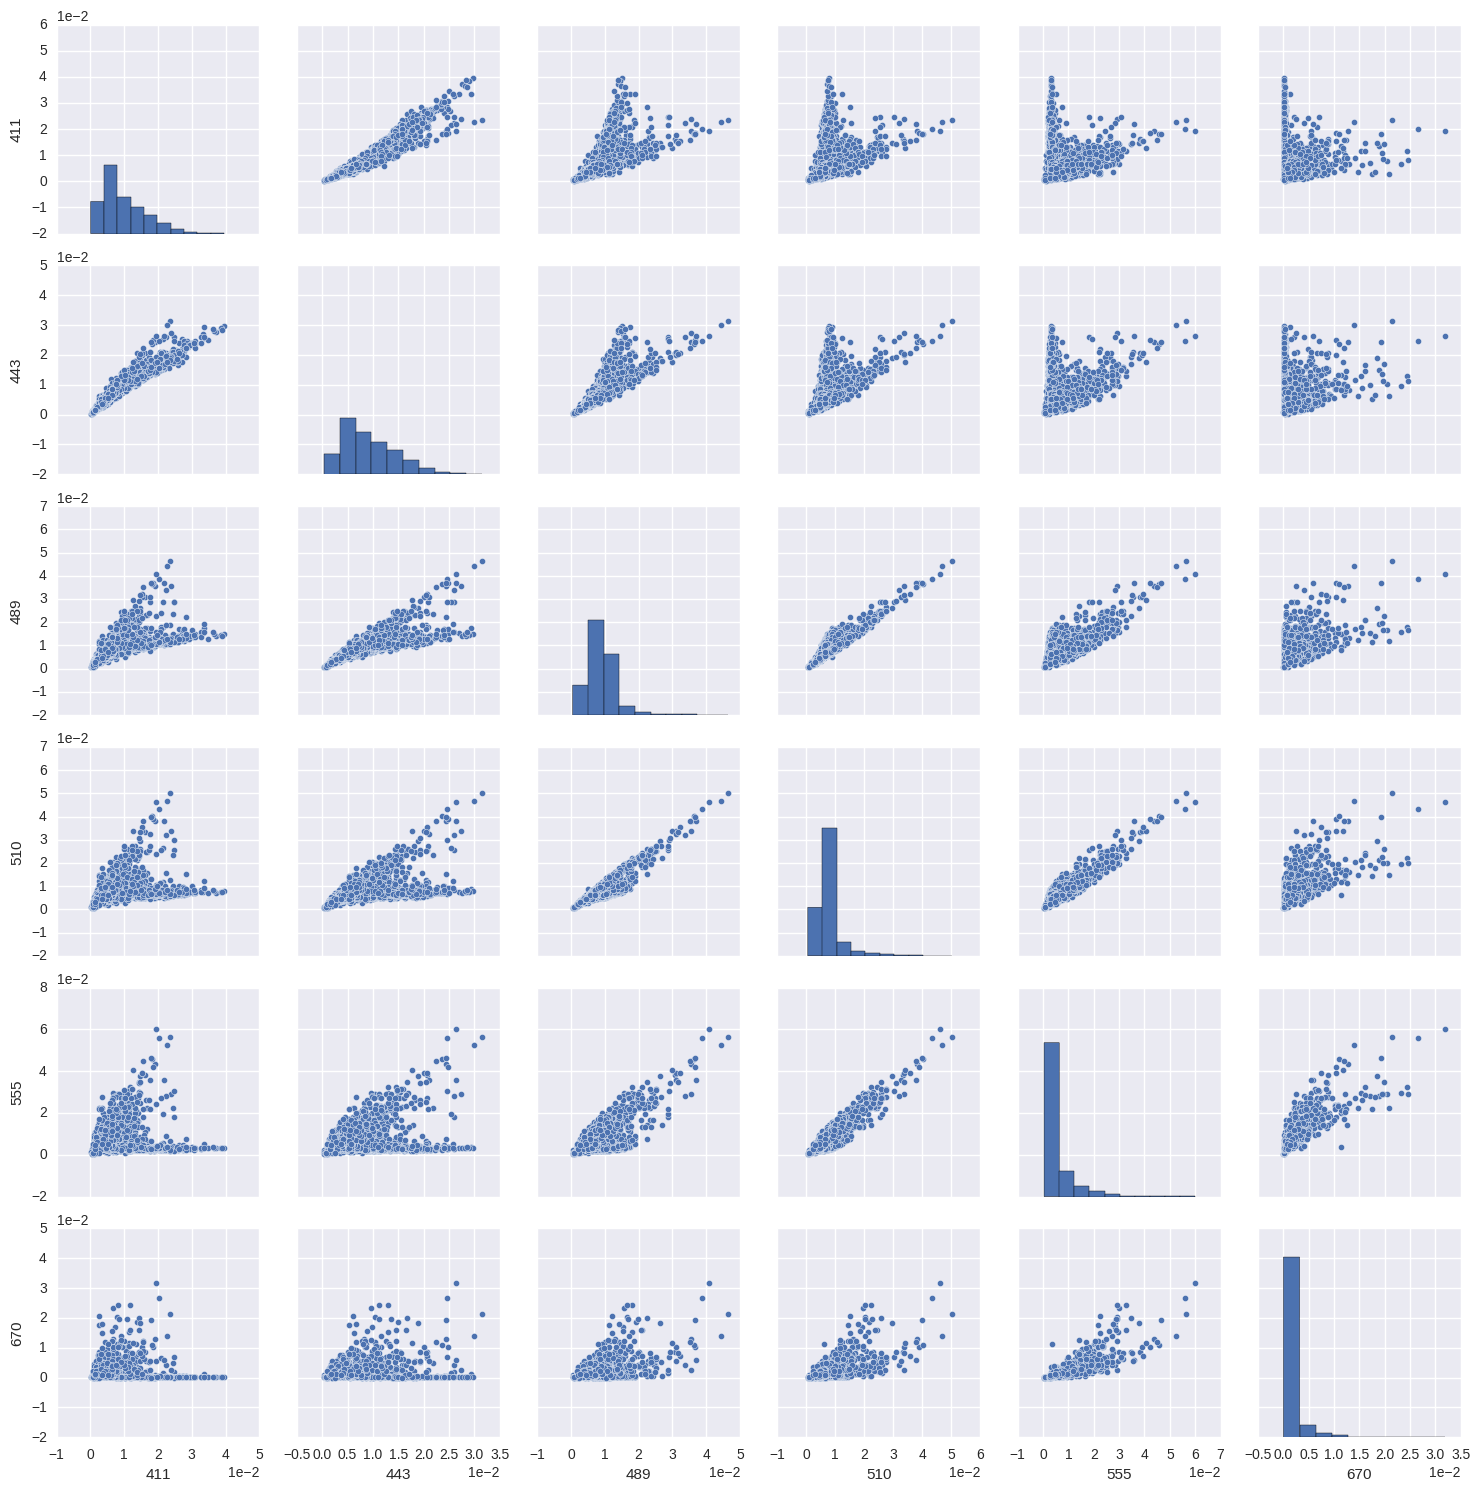

In [28]:
SB.set(font_scale=1)
SB.pairplot(df.loc[:,[411, 443, 489, 510, 555, 670]]);

There is still what appears to be significant correlation, in particular between 489 and 510, and between 510 and 555. To a lesser extent, this is also visible betwen 411 and 443. PCA, which is well suited for unlabeled data, might be a good step in the preprocessing chain, as a feature reduction/extraction method. First I'll give myself the luxury of the full table above, just Rrs features for now.
While these are on the same scale, I will still go ahead and standardize them.

Running PCA analysis...

In [17]:
def PlotPCARes(classifier, data):
    f,ax = pl.subplots(ncols=2,figsize=(12,6))
    n = data.shape[1]
    ax[0].bar(range(1, n+1),classifier.explained_variance_ratio_, align='center', color='skyblue');
    ax[0].step(range(1, n+1),NP.cumsum(classifier.explained_variance_ratio_), where='mid')
    ax[0].hlines(0.85, 0, n+2, linestyles='--', linewidth=2, label='feature selection cutoff')
    ax[0].set_xticks(range(1,n+1),['PC%d' %i for i in range(n+1)])
    ax[0].set_ylim((0,1))
    ax[0].set_title('PCA Summary')
    ax[0].legend(loc='best')
    ax[1].set_title('First Two PCs')
    ax[1].scatter(data[:,0], data[:,1], alpha=0.1);
    ax[1].set_xlabel('PC1')
    ax[1].set_ylabel('PC2')

In [29]:
sc_small = StandardScaler()
dataStd_small = sc_small.fit_transform(df.loc[:,[411, 443, 489, 510, 555, 670]].values)
dfStd_small = PD.DataFrame(dataStd_small,columns=[411, 443, 489, 510, 555, 670])
dfStd_small.describe()

,411,443,489,510,555,670
count,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03
mean,1.108376e-16,-5.338676e-17,8.913188e-17,-4.858380e-17,1.763010e-16,-3.461365e-17
std,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00
min,-1.499165e+00,-1.686430e+00,-1.857760e+00,-1.533065e+00,-9.370233e-01,-4.819356e-01
25%,-7.504352e-01,-7.537173e-01,-6.419132e-01,-4.568864e-01,-5.049955e-01,-4.158278e-01
50%,-2.972898e-01,-2.310136e-01,-1.214855e-01,-2.310029e-01,-3.506027e-01,-3.440910e-01
75%,6.081378e-01,6.284834e-01,4.419674e-01,7.039356e-02,-9.454504e-03,-7.148734e-02
max,4.516979e+00,4.154953e+00,8.154232e+00,9.130229e+00,8.864605e+00,1.162061e+01


In [45]:
pca_sm = PCA()
transformedData = pca_sm.fit_transform(dataStd_small)
print(pca_sm.explained_variance_)
print(pca_sm.explained_variance_ratio_)

[ 3.59   2.055  0.307  0.035  0.009  0.004]
[ 0.598  0.343  0.051  0.006  0.001  0.001]


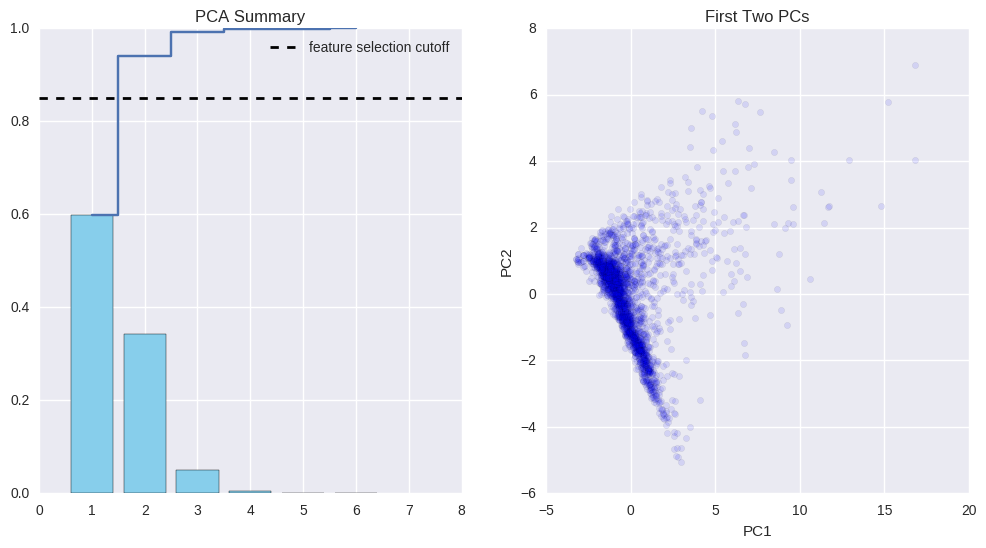

In [47]:
PlotPCARes(pca_sm, transformedData)

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist, pdist

In [59]:
wInClustSumSq = []
silScore = []
centroids = []
maxClust = 20
for iClust in range(2,maxClust+1):
    km = KMeans(n_clusters=iClust, init='k-means++', n_init=10, max_iter=500, random_state=0, n_jobs=-1)
    km.fit(transformedData[:,:2])
    labels=km.labels_
    wInClustSumSq.append(km.inertia_)
    silScore.append(silhouette_score(transformedData, labels, metric='euclidean'))
    centroids.append(km.cluster_centers_)

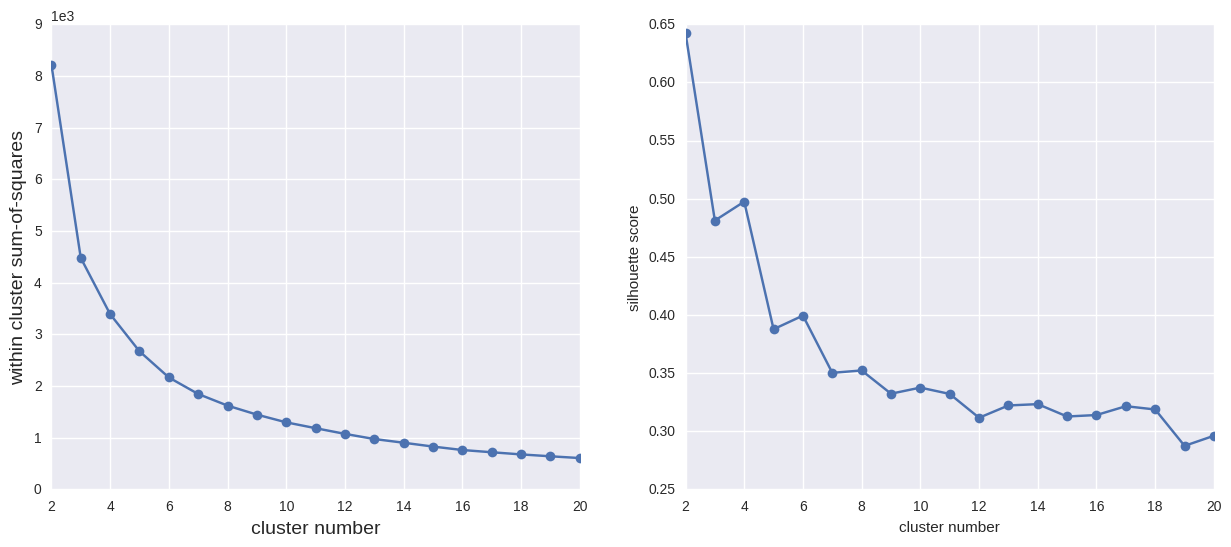

In [56]:
f,axs = pl.subplots(ncols=2,figsize=(15,6))
axs[0].plot(range(2, maxClust+1), wInClustSumSq, marker='o')
axs[0].set_xlabel('cluster number', fontsize=14)
axs[0].set_ylabel('within cluster sum-of-squares', fontsize=14);
axs[1].plot(range(2, maxClust+1), silScore, marker='o')
axs[1].set_xlabel('cluster number')
axs[1].set_ylabel('silhouette score')

.. TO BE NUE